**Scenario A**

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\supun\AppData\Local\Temp\ipykernel_13920\3156972243.py:1: SyntaxWarning: invalid escape sequence '\d'
  """""


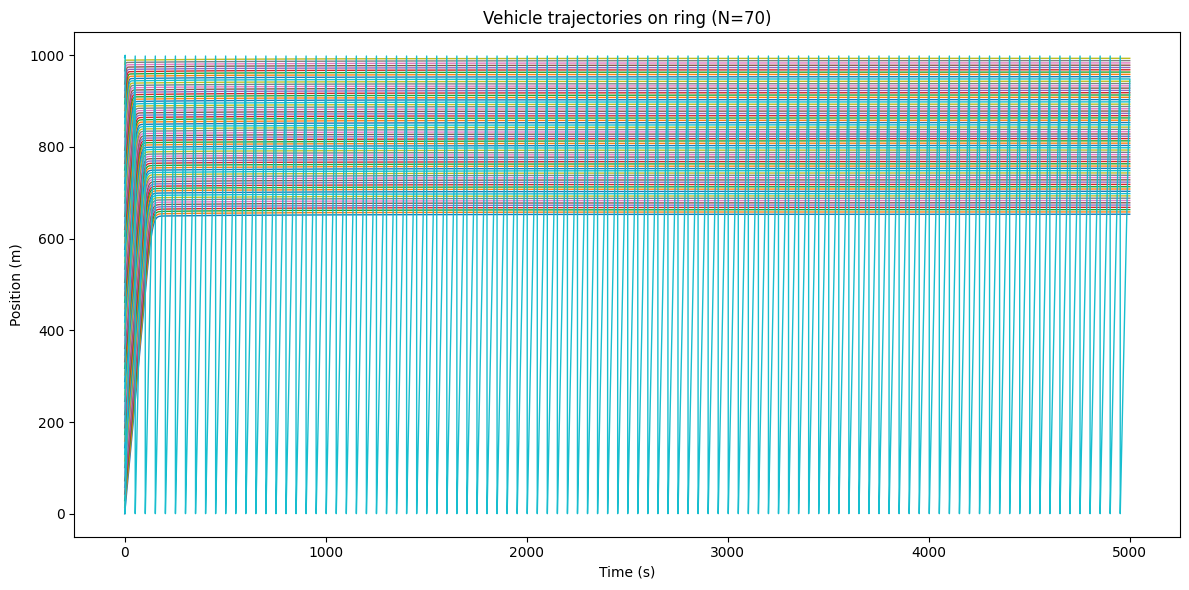

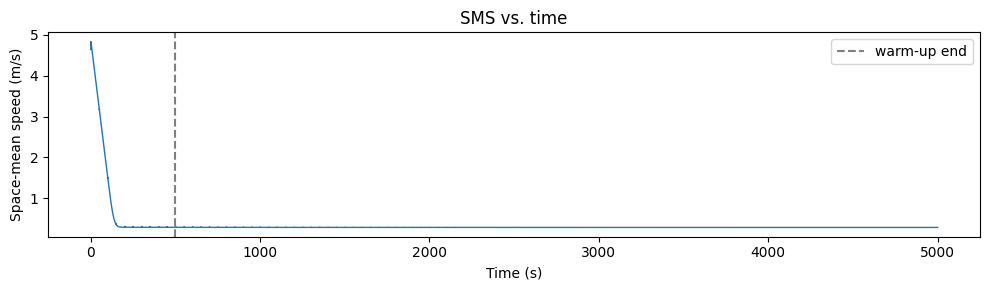

Steady SMS ≈ 0.29 m/s, density = 0.070 veh/m, flow ≈ 0.020 veh/s


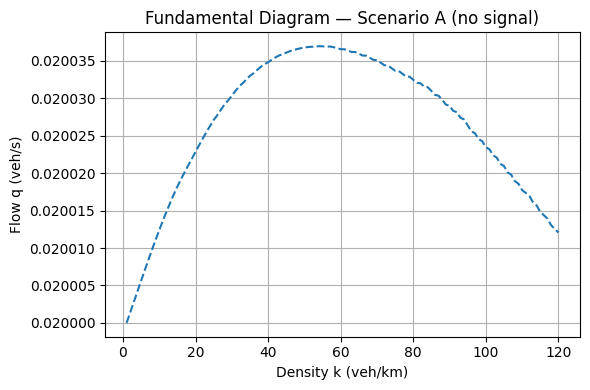

In [3]:
"""""
This Python script simulates traffic on a $1000m$ ring using Newell's car-following model and then builds the corresponding fundamental diagram. 
First, it defines model parameters—desired time gap ($\tau$), vehicle length, time step ($\delta t$), and free-flow speed—and ring settings 
(length, total simulation time, and warm-up period). The simulate($N$) function initializes $N$ vehicles evenly around the ring and, at each time 
step, computes the bumper-to-bumper gap to the vehicle ahead (with wrap-around), clamps any negative gaps to zero, sets each vehicle's speed to the 
minimum of gap/$\tau$ and free-flow speed, advances positions modulo the ring length, and records both the individual trajectories and the 
space-mean speed (SMS). In main(), the user is prompted to enter a vehicle count $N_0$ between $1$ and $120$; the script then runs the simulation
for $N_0$, plots the time–space trajectories and SMS vs. time (marking the warm-up cutoff), computes the steady-state SMS (averaged after warm-up), 
density, and flow $q = k\hat{v}$ and prints those values. Finally, to generate the fundamental diagram, it loops $N$ from $1$ to $120$, reruns the 
simulation for each $N$ extracts the steady-state SMS, computes flow $q = k\hat{v}$ and plots flow versus density (in $veh/km$), yielding the 
characteristic triangular relationship between flow and density.
"""""
import numpy as np
import matplotlib.pyplot as plt

tau       = 2.0    
L_vehicle = 5.0    
dt        = 0.1   
v_f       = 20.0  

L_road   = 1000.0  
T_total  = 5000.0  
warmup   = 500.0   

def simulate(N, T=T_total):
    n_steps = int(T / dt)
    x    = np.linspace(0, L_road - L_vehicle, N)
    traj = np.zeros((n_steps, N))
    SMS  = np.zeros(n_steps)

    for t in range(n_steps):
        traj[t] = x.copy()
        x_next = np.roll(x, -1)
        gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road
        gaps = np.maximum(gaps, 0.0)
        v = np.minimum(gaps / tau, v_f)
        x = (x + v * dt) % L_road
        SMS[t] = v.mean()

    return traj, SMS

def main():
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            else:
                print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")

    traj, SMS = simulate(N0)
    times = np.arange(len(SMS)) * dt

    plt.figure(figsize=(12, 6))
    for i in range(N0):
        plt.plot(times, traj[:, i], lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Vehicle trajectories on ring (N={N0})')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.plot(times, SMS, lw=1)
    plt.axvline(warmup, color='gray', ls='--', label='warm‑up end')
    plt.xlabel('Time (s)')
    plt.ylabel('Space‑mean speed (m/s)')
    plt.title('SMS vs. time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    warmup_steps = int(warmup / dt)
    steady_sms   = SMS[warmup_steps:].mean()
    density0     = N0 / L_road        
    flow0        = density0 * steady_sms  
    print(f"Steady SMS ≈ {steady_sms:.2f} m/s, density = {density0:.3f} veh/m, flow ≈ {flow0:.3f} veh/s")

    Ns        = np.arange(1, 121)          
    densities = Ns / L_road              
    flows     = np.zeros_like(densities)

    for idx, N in enumerate(Ns):
        _, SMS_k = simulate(N)
        steady_sms_k = SMS_k[warmup_steps:].mean()
        flows[idx] = densities[idx] * steady_sms_k

    plt.figure(figsize=(6, 4))
    plt.plot(densities * 1000, flows, '--')
    plt.xlabel('Density k (veh/km)')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Fundamental Diagram — Scenario A (no signal)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

**Scenario B**

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\supun\AppData\Local\Temp\ipykernel_13920\997392242.py:1: SyntaxWarning: invalid escape sequence '\i'
  """


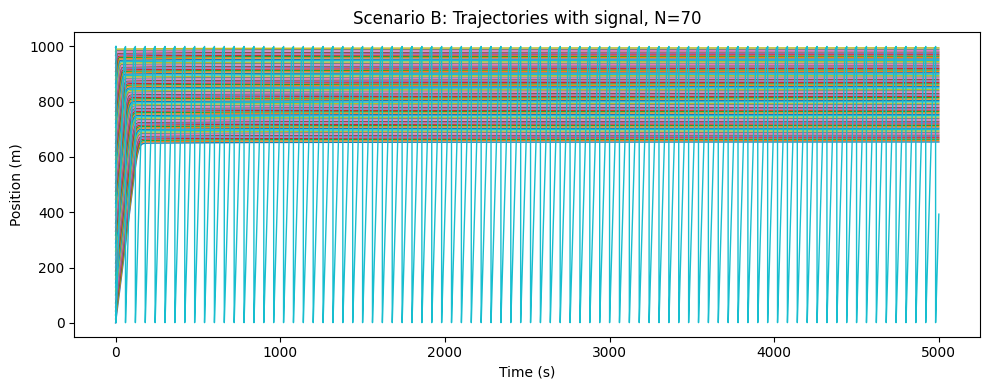

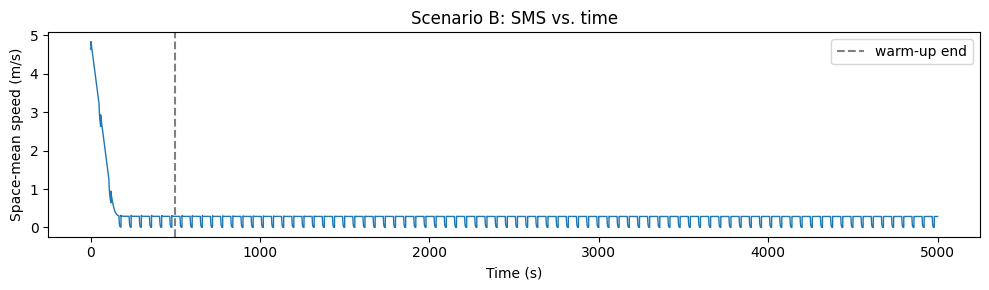

Steady SMS ≈ 0.24 m/s, density = 0.070 veh/m, flow ≈ 0.017 veh/s


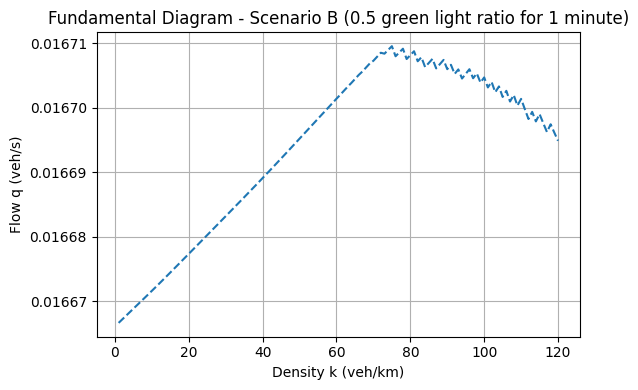

In [2]:
"""
This script extends the ring-road simulation to include a single traffic signal with a fixed green-to-cycle ratio $g = 0.5$. After defining 
Newell’s car-following parameters (time gap $\tau$, vehicle length, time step, free‐flow speed) and ring settings (length, total run time, 
warm-up period), the simulate_signal($N$) function initializes $N$ vehicles evenly spaced around the loop. At each time step it ($1$) records 
current positions, ($2$) determines whether the signal is green or red based on $phase < gT_{cycle}$, ($3$) computes inter-vehicle gaps 
(wrapping around the ring), clamping negatives to zero, ($4$) if red, further limits gaps by the distance to the stop line at $x = 0$, 
($5$) updates speeds via v = min(gap/$\tau$, $\v_f$)and advances positions modulo the ring, and ($6$) records the space-mean speed. 
In main(), the user enters a vehicle count $N_0 \in [1, 120]$ the code then simulates and plots the time-space trajectories and SMS vs. time 
(marking the warm-up cutoff), computes the steady-state SMS (averaged after warm-up), density, and flow $q = k\hat{v}$, and finally sweeps 
$N = 1$ to $120$ to build and plot the fundamental diagram of flow vs. density ($veh/km$), illustrating how the $30s$ green/$30s$ red cycle 
constrains capacity.
"""
import numpy as np
import matplotlib.pyplot as plt

tau       = 2.0   
L_vehicle = 5.0    
dt        = 0.1    
v_f       = 20.0   

L_road   = 1000.0  
T_total  = 5000.0  
warmup   = 500.0   
T_cycle  = 60.0    
g        = 0.5    

def simulate_signal(N, T=T_total):
    n_steps = int(T / dt)
    x = np.linspace(0, L_road - L_vehicle, N)
    traj = np.zeros((n_steps, N))
    SMS  = np.zeros(n_steps)

    for t in range(n_steps):
        traj[t] = x.copy()
        phase    = (t * dt) % T_cycle
        is_green = (phase < g * T_cycle)
        x_next = np.roll(x, -1)
        gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road
        gaps = np.maximum(gaps, 0.0)


        if not is_green:
            d_signal = (L_road - x - L_vehicle) % L_road
            gaps = np.minimum(gaps, d_signal)

        
        v = np.minimum(gaps / tau, v_f)
        x = (x + v * dt) % L_road
    
        SMS[t] = v.mean()

    return traj, SMS

def main():
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")

    traj, SMS = simulate_signal(N0)
    times = np.arange(len(SMS)) * dt

    plt.figure(figsize=(10, 4))
    for i in range(N0):
        plt.plot(times, traj[:, i], lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Scenario B: Trajectories with signal, N={N0}')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 3))
    plt.plot(times, SMS, lw=1)
    plt.axvline(warmup, color='gray', ls='--', label='warm‑up end')
    plt.xlabel('Time (s)')
    plt.ylabel('Space‑mean speed (m/s)')
    plt.title('Scenario B: SMS vs. time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    warmup_steps = int(warmup / dt)
    steady_sms   = SMS[warmup_steps:].mean()
    density0     = N0 / L_road            
    flow0        = density0 * steady_sms  
    print(f"Steady SMS ≈ {steady_sms:.2f} m/s, density = {density0:.3f} veh/m, flow ≈ {flow0:.3f} veh/s")

    
    Ns        = np.arange(1, 121)        
    densities = Ns / L_road               
    flows     = np.zeros_like(densities)

    for idx, N in enumerate(Ns):
        _, SMS_k = simulate_signal(N)
        steady_sms_k = SMS_k[warmup_steps:].mean()
        flows[idx] = densities[idx] * steady_sms_k

    plt.figure(figsize=(6, 4))
    plt.plot(densities * 1000, flows, '--')
    plt.xlabel('Density k (veh/km)')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Fundamental Diagram - Scenario B (0.5 green light ratio for 1 minute)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

**Scenario B - change of FD with the green light ratio**

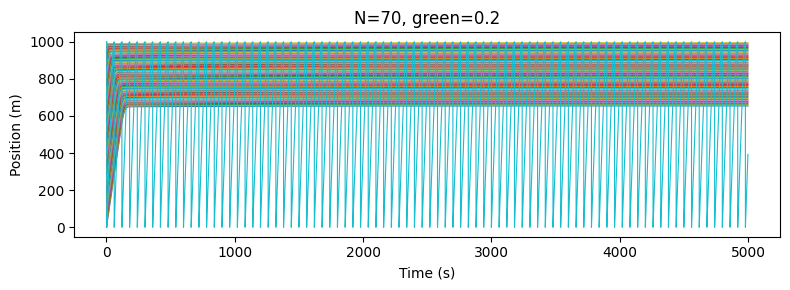

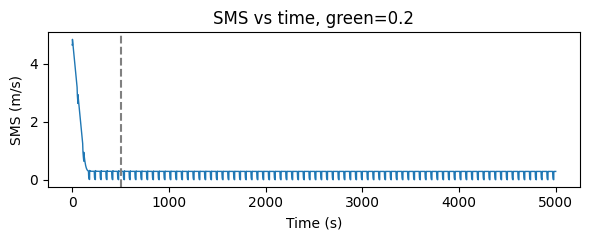

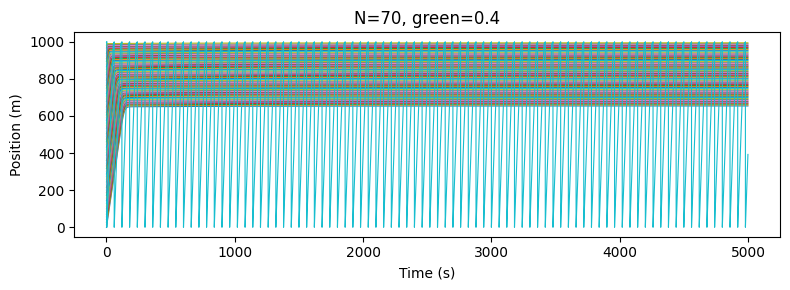

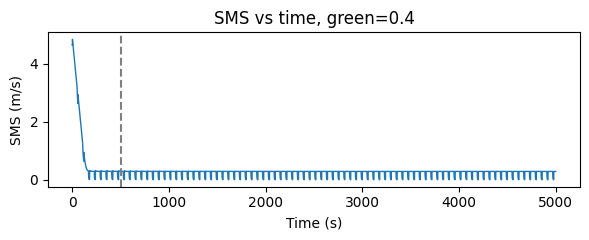

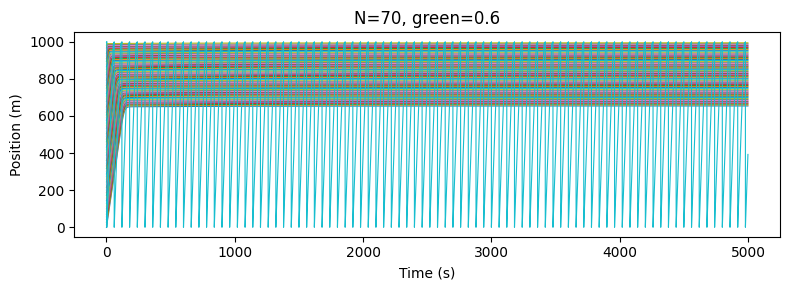

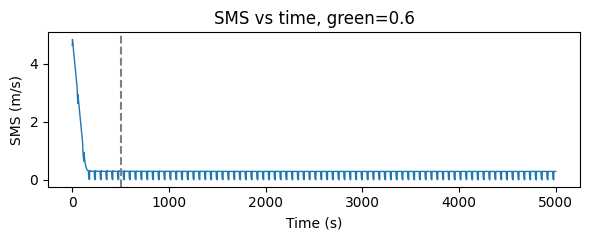

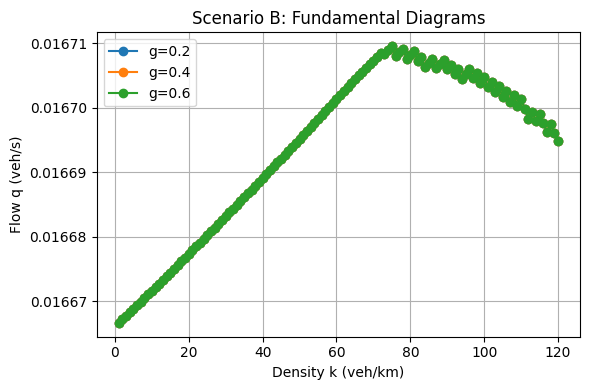

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

tau       = 2.0     
L_vehicle = 5.0     
dt        = 0.1    
v_f       = 20.0    

L_road   = 1000.0   
T_total  = 5000.0   
warmup   = 500.0    
T_cycle  = 60.0     

def simulate_signal(N, g, T=T_total):
    """
    Simulate N vehicles on a ring with a signal green for fraction g of each 60s cycle.
    Returns:
      traj: (n_steps × N) positions over time
      SMS:  (n_steps,)   space‑mean speeds over time
    """
    n_steps = int(T / dt)
    x       = np.linspace(0, L_road - L_vehicle, N)
    traj    = np.zeros((n_steps, N))
    SMS     = np.zeros(n_steps)

    for t in range(n_steps):
        traj[t] = x.copy()
        phase    = (t * dt) % T_cycle
        is_green = (phase < g * T_cycle)


        x_next = np.roll(x, -1)
        gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road
        gaps = np.maximum(gaps, 0.0)

        
        if not is_green:
            d_signal = (L_road - x - L_vehicle) % L_road
            gaps = np.minimum(gaps, d_signal)

    
        v = np.minimum(gaps / tau, v_f)
        x = (x + v * dt) % L_road
        SMS[t] = v.mean()

    return traj, SMS

def main():
    
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")

    green_ratios = [0.2, 0.4, 0.6]

    for g in green_ratios:
        traj, SMS = simulate_signal(N0, g)
        times = np.arange(len(SMS)) * dt

        
        plt.figure(figsize=(8, 3))
        for i in range(N0):
            plt.plot(times, traj[:, i], lw=0.8)
        plt.title(f'N={N0}, green={g:.1f}')
        plt.xlabel('Time (s)'); plt.ylabel('Position (m)')
        plt.tight_layout()
        plt.show()

        
        plt.figure(figsize=(6, 2.5))
        plt.plot(times, SMS, lw=1)
        plt.axvline(warmup, color='gray', ls='--')
        plt.title(f'SMS vs time, green={g:.1f}')
        plt.xlabel('Time (s)'); plt.ylabel('SMS (m/s)')
        plt.tight_layout()
        plt.show()

    
    Ns        = np.arange(1, 121)
    densities = Ns / L_road  

    plt.figure(figsize=(6, 4))
    for g in green_ratios:
        flows = []
        for N in Ns:
            _, SMS_k = simulate_signal(N, g)     
            steady_sms_k = SMS_k[int(warmup/dt):].mean()
            flows.append((N / L_road) * steady_sms_k)
        plt.plot(densities*1000, flows, 'o-', label=f'g={g:.1f}')

    plt.xlabel('Density k (veh/km)')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Scenario B: Fundamental Diagrams')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()